# Load pretrain model

In [1]:
from Score_Matching import *
from FLIPD import *
import torch 
from tqdm import tqdm
import numpy as np
import os

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
score_model = ScoreNet(
    image_dim=(1,28,28), 
    use_condition=True, 
    num_classes=10, 
    device = device
)

In [4]:
# Load model with lastest checkpoint
def find_last_folder():
    all_subdirs = ['./Score_Matching/checkpoints/' + d for d in os.listdir('./Score_Matching/checkpoints/') if os.path.isdir(os.path.join('./Score_Matching/checkpoints/', d))]
    return max(all_subdirs, key=os.path.getmtime)

last_checkpoint = find_last_folder()
print("Loading model from checkpoint: ", last_checkpoint)

score_model.model.load_state_dict(torch.load(last_checkpoint + '/model.pt', map_location=device))

Loading model from checkpoint:  ./Score_Matching/checkpoints/20250114-100745


<All keys matched successfully>

# Test model

100%|██████████| 100/100 [00:03<00:00, 29.36it/s]


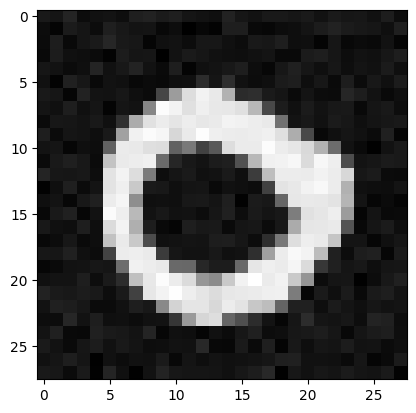

In [5]:
# Sampling 
sampler = Predictor_Corrector_Sampler(
    score_model=score_model, 
    signal_to_noise_ratio=0.16, 
    device=device,
    epsilon=1e-6
)

image_state = sampler.sample(
    num_steps=100, 
    batch_size=1, 
    sample_condition=torch.tensor([0]).to(device)
)

# show image
import matplotlib.pyplot as plt
plt.imshow(image_state.squeeze().cpu().detach().numpy(), cmap='gray')

# Calculate FLIPD 

In [6]:
metric = FLIPD(
    score_model=score_model
)

In [41]:
batch_size = 1 
condition_label = [1]

x = torch.randn(batch_size, 1, 28, 28).to(device)
y = torch.tensor(condition_label).to(device)
t_0 = torch.ones(batch_size).to(device) * (0.999)

# Compute the FLIPD score
metric_score = metric.flipd(t_0, x, y)
print("FLIPD score: ", metric_score)
print(metric_score.shape)

FLIPD score:  tensor([[[[795.6243, 793.1483, 795.6552, 784.0037, 786.3923, 790.1141, 795.6566,
           795.6565, 785.6881, 784.1483, 795.6566, 795.6566, 795.6566, 794.9559,
           791.3519, 795.6564, 795.6536, 795.6214, 795.6541, 795.6405, 795.6559,
           795.6531, 784.9178, 793.7424, 795.6515, 795.6566, 785.4334, 795.2344],
          [795.6566, 795.6566, 795.6566, 795.3790, 795.6566, 795.6454, 785.8324,
           795.5817, 791.4297, 795.6566, 795.6566, 795.4260, 795.6560, 785.9459,
           795.6566, 784.1838, 784.4733, 790.2339, 795.6033, 795.6550, 795.6562,
           795.6566, 795.6539, 795.5543, 795.5062, 788.5900, 795.5455, 795.6566],
          [794.4624, 784.7955, 784.1469, 794.5490, 795.6566, 795.6566, 785.3120,
           795.6563, 784.1179, 795.6566, 792.2250, 794.8821, 792.5239, 793.9702,
           795.6566, 784.0026, 795.6566, 792.6580, 795.6440, 784.7228, 795.6522,
           795.6541, 795.6216, 795.6566, 795.6566, 795.6566, 784.2751, 794.5989],
          [